In [1]:
from openmm import unit, Platform
from openmm.app import Topology, Simulation
from openmm import System, VerletIntegrator, NonbondedForce
import openmm.app as app
import numpy as np

In [2]:
import torch

# Parameters for Argon (in OpenMM units)
sigma = 0.3405  # nm
epsilon = 0.997 # kJ/mol

def lj_energy(coords_flat):
    coords = coords_flat.view(-1, 3)
    energy = 0.0
    for i in range(3):
        for j in range(i+1, 3):
            rij = torch.norm(coords[i] - coords[j])
            sr6 = (sigma / rij) ** 6
            sr12 = sr6 * sr6
            energy += 4 * epsilon * (sr12 - sr6)
    return energy


In [3]:
# Match initial positions
positions_array = np.array([
    [0.0, 0.0, 0.0],
    [0.4, 0.0, 0.0],
    [0.0, 0.4, 0.0]
])
coords_torch = torch.tensor(positions_array, dtype=torch.float64, requires_grad=True)

# Compute Hessian: 9x9 matrix
ref_hess_torch = torch.autograd.functional.hessian(lj_energy, coords_torch.view(-1))
ref_hess = ref_hess_torch.detach().cpu().numpy()

In [4]:
# === Create simple 3-atom argon system ===
def create_argon_lj_system():
    system = System()
    lj = NonbondedForce()
    lj.setNonbondedMethod(NonbondedForce.NoCutoff)

    # Argon: epsilon = 0.997 kJ/mol, sigma = 0.3405 nm
    sigma = 0.3405
    epsilon = 0.997
    charge = 0.0

    positions = unit.Quantity([
        [0.0, 0.0, 0.0],
        [0.4, 0.0, 0.0],
        [0.0, 0.4, 0.0]
    ], unit.nanometer)

    top = Topology()
    chain = top.addChain()
    res = top.addResidue("ARG", chain)
    for i in range(3):
        system.addParticle(39.948 * unit.amu)  # argon mass
        top.addAtom("Ar", app.Element.getBySymbol("Ar"), res)
        lj.addParticle(charge, sigma, epsilon)

    system.addForce(lj)
    return system, top, positions

In [5]:
def _get_openmm_forces(context, positions):
    context.setPositions(positions)
    state = context.getState(getForces=True)
    forces = state.getForces(asNumpy=True).value_in_unit(unit.kilojoule_per_mole / unit.nanometer)
    return forces.flatten()

In [6]:
system, topology, positions = create_argon_lj_system()
integrator = VerletIntegrator(1 * unit.femtoseconds)
platform = Platform.getPlatformByName("CPU")
simulation = Simulation(topology, system, integrator, platform)
simulation.context.setPositions(positions)

import sys, os
repo_root = os.path.abspath(os.path.join("/home/armin/Documents/GADES/examples/LJ_Validation/", '..', '..'))
sys.path.insert(0, os.path.join(repo_root, 'GADES'))

from utils import (
    compute_hessian_force_fd_block_serial,
    compute_hessian_force_fd_richardson
)

epsilons = np.logspace(-6, -1, 15)
errors_fd, errors_r1, errors_r3,  errors_r5= [], [], [], []

# Ground truth: extremely fine FD
#ref_hess = compute_hessian_force_fd_block_serial(system, positions, None, 1e-7, "CPU")

for eps in epsilons:
    h_fd = compute_hessian_force_fd_block_serial(system, positions, None, eps, "CPU")
    h_r1 = compute_hessian_force_fd_richardson(system, positions, None, eps, "CPU", factors=[1, 0.5])
    h_r3 = compute_hessian_force_fd_richardson(system, positions, None, eps, "CPU", factors=[1, 0.5, 0.25, 0.125])
    h_r5 = compute_hessian_force_fd_richardson(system, positions, None, eps, "CPU", factors=[1, 0.5, 0.25, 0.125, 0.0625])

    errors_fd.append(np.linalg.norm(h_fd - ref_hess) / np.linalg.norm(ref_hess))
    errors_r1.append(np.linalg.norm(h_r1 - ref_hess) / np.linalg.norm(ref_hess))
    errors_r3.append(np.linalg.norm(h_r3 - ref_hess) / np.linalg.norm(ref_hess))
    errors_r5.append(np.linalg.norm(h_r5 - ref_hess) / np.linalg.norm(ref_hess))


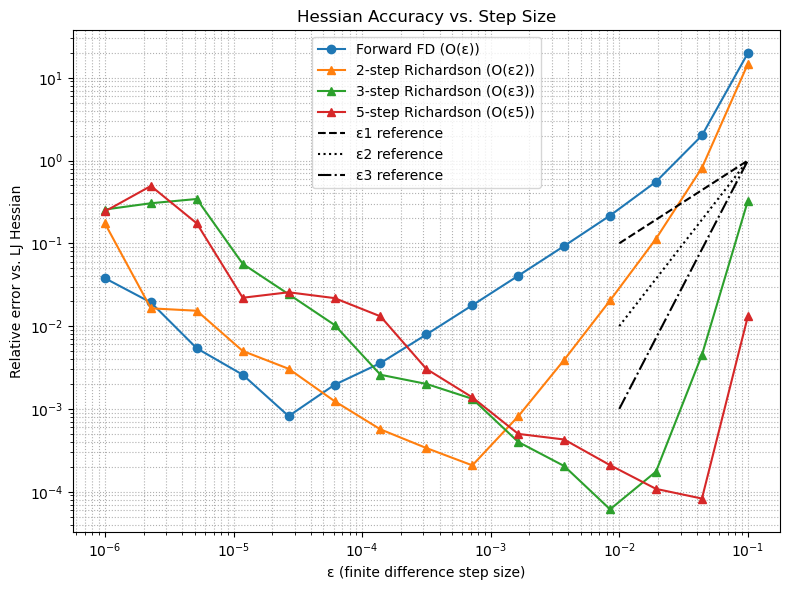

In [7]:
import matplotlib.pyplot as plt

# --- Plotting ---
plt.figure(figsize=(8,6))
plt.loglog(epsilons, errors_fd, 'o-', label='Forward FD (O(ε))')
plt.loglog(epsilons, errors_r1, '^-', label='2-step Richardson (O(ε2))')
plt.loglog(epsilons, errors_r3, '^-', label='3-step Richardson (O(ε3))')
plt.loglog(epsilons, errors_r5, '^-', label='5-step Richardson (O(ε5))')


# Reference slopes
ref_eps = np.array([1e-2, 1e-1])
plt.loglog(ref_eps, 1e1 * ref_eps, 'k--', label='ε1 reference')
plt.loglog(ref_eps, 1e2 * ref_eps**2, 'k:', label='ε2 reference')
plt.loglog(ref_eps, 1e3 * ref_eps**3, 'k-.', label='ε3 reference')
#plt.loglog(ref_eps, 1e5 * ref_eps**5, 'k--', label='ε5')

plt.xlabel("ε (finite difference step size)")
plt.ylabel("Relative error vs. LJ Hessian")
plt.title("Hessian Accuracy vs. Step Size")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()


In [8]:
1e0 * ref_eps

array([0.01, 0.1 ])

In [9]:
def lj_hessian_analytical(positions, sigma=0.3405, epsilon=0.997):
    """
    Compute analytical Hessian for Lennard-Jones potential (no cutoff).

    Parameters:
    - positions: (N, 3) array of atom positions in nm
    - sigma, epsilon: LJ parameters

    Returns:
    - Hessian: (3N, 3N) numpy array
    """
    N = positions.shape[0]
    H = np.zeros((3 * N, 3 * N))

    for i in range(N):
        for j in range(i + 1, N):
            rij_vec = positions[i] - positions[j]
            r = np.linalg.norm(rij_vec)
            u = rij_vec / r

            sr = sigma / r
            sr6 = sr ** 6
            sr12 = sr6 ** 2

            dVdr = 24 * epsilon / r * (2 * sr12 - sr6)
            d2Vdr2 = 24 * epsilon / r**2 * (26 * sr12 - 7 * sr6)

            outer = np.outer(u, u)
            I = np.eye(3)
            hess_ij = (d2Vdr2 - dVdr / r) * outer + (dVdr / r) * I

            # Place in global Hessian
            for a in range(3):
                for b in range(3):
                    H[3*i + a, 3*i + b] += hess_ij[a, b]
                    H[3*j + a, 3*j + b] += hess_ij[a, b]
                    H[3*i + a, 3*j + b] -= hess_ij[a, b]
                    H[3*j + a, 3*i + b] -= hess_ij[a, b]

    return H

In [12]:
positions_nunit = np.array([
    [0.0, 0.0, 0.0],
    [0.4, 0.0, 0.0],
    [0.0, 0.4, 0.0]
])  # already in nm

ref_hess_anal = lj_hessian_analytical(positions_nunit)

epsilons = np.logspace(-3, -1, 15)
errors_fd, errors_r1, errors_r3,  errors_r5= [], [], [], []

for eps in epsilons:
    h_fd = compute_hessian_force_fd_block_serial(system, positions, None, eps, "CPU")
    h_r1 = compute_hessian_force_fd_richardson(system, positions, None, eps, "CPU", factors=[1, 0.5])
    h_r3 = compute_hessian_force_fd_richardson(system, positions, None, eps, "CPU", factors=[1, 0.5, 0.25, 0.125])
    h_r5 = compute_hessian_force_fd_richardson(system, positions, None, eps, "CPU", factors=[1, 0.5, 0.25, 0.125, 0.0625])

    errors_fd.append(np.linalg.norm(h_fd - ref_hess_anal) / np.linalg.norm(ref_hess_anal))
    errors_r1.append(np.linalg.norm(h_r1 - ref_hess_anal) / np.linalg.norm(ref_hess_anal))
    errors_r3.append(np.linalg.norm(h_r3 - ref_hess_anal) / np.linalg.norm(ref_hess_anal))
    errors_r5.append(np.linalg.norm(h_r5 - ref_hess_anal) / np.linalg.norm(ref_hess_anal))


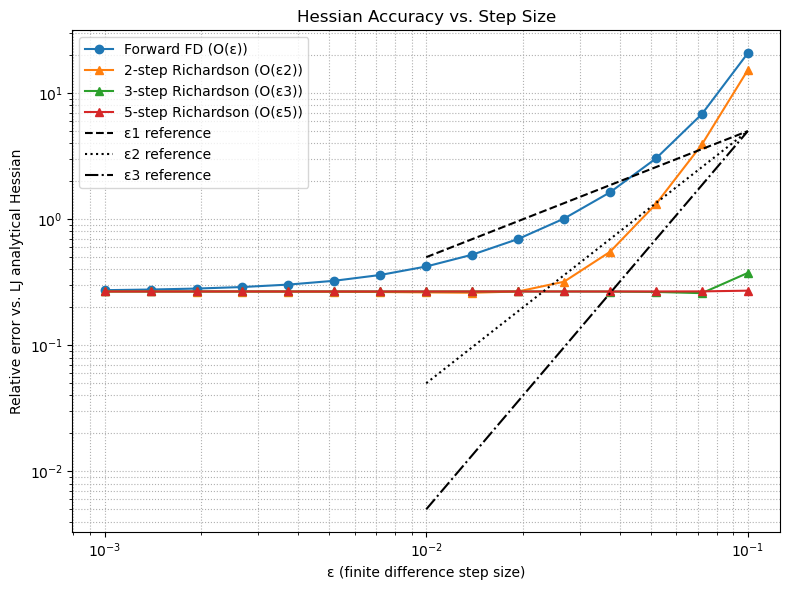

In [17]:
import matplotlib.pyplot as plt

# --- Plotting ---
plt.figure(figsize=(8,6))
plt.loglog(epsilons, errors_fd, 'o-', label='Forward FD (O(ε))')
plt.loglog(epsilons, errors_r1, '^-', label='2-step Richardson (O(ε2))')
plt.loglog(epsilons, errors_r3, '^-', label='3-step Richardson (O(ε3))')
plt.loglog(epsilons, errors_r5, '^-', label='5-step Richardson (O(ε5))')


# Reference slopes
ref_eps = np.array([1e-2, 1e-1])
plt.loglog(ref_eps, 5e1 * ref_eps, 'k--', label='ε1 reference')
plt.loglog(ref_eps, 5e2 * ref_eps**2, 'k:', label='ε2 reference')
plt.loglog(ref_eps, 5e3 * ref_eps**3, 'k-.', label='ε3 reference')
#plt.loglog(ref_eps, 1e5 * ref_eps**5, 'k--', label='ε5')

plt.xlabel("ε (finite difference step size)")
plt.ylabel("Relative error vs. LJ analytical Hessian")
plt.title("Hessian Accuracy vs. Step Size")
plt.legend()
plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()


In [22]:
def compare_spectrum_and_soft_mode(H_ref, H_test, label_ref="Reference", label_test="Test"):
    # Diagonalize both Hessians
    evals_ref, evecs_ref = np.linalg.eigh(H_ref)
    evals_test, evecs_test = np.linalg.eigh(H_test)

    # Sort eigenvalues (and vectors) ascending
    idx_ref = np.argsort(evals_ref)
    idx_test = np.argsort(evals_test)

    evals_ref = evals_ref[idx_ref]
    evals_test = evals_test[idx_test]
    evecs_ref = evecs_ref[:, idx_ref]
    evecs_test = evecs_test[:, idx_test]

    # Compare full spectrum
    #print(f"\nEigenvalue spectrum ({label_ref} vs {label_test}):")
    #for i in range(len(evals_ref)):
        #print(f"Mode {i:2d}: {evals_ref[i]: .4e} vs {evals_test[i]: .4e}")

    # Compare softest mode (lowest eigenvalue)
    v_ref = evecs_ref[:, 0]
    v_test = evecs_test[:, 0]

    # Normalize (should be already, but to be safe)
    v_ref /= np.linalg.norm(v_ref)
    v_test /= np.linalg.norm(v_test)

    # Cosine similarity = dot product
    cos_sim = np.abs(np.dot(v_ref, v_test))

    #print(f"\nSoftest mode eigenvalue: {evals_ref[0]:.4e} ({label_ref}) vs {evals_test[0]:.4e} ({label_test})")
    #print(f"Cosine similarity between softest eigenvectors: {cos_sim:.6f}")

    return {
        "softest_eval_ref": evals_ref[0],
        "softest_eval_test": evals_test[0],
        "cosine_similarity": cos_sim,
        "evals_ref": evals_ref,
        "evals_test": evals_test
    }

In [30]:
softest_evals_fd, cosine_sims_fd = [], []
softest_evals_e2, cosine_sims_e2 = [], []
epsilons = np.logspace(-3, -1, 15)

for eps in epsilons:
    H_test = compute_hessian_force_fd_block_serial(system, positions, None, eps, "CPU")
    res = compare_spectrum_and_soft_mode(ref_hess_anal, H_test)
    softest_evals_fd.append((res["softest_eval_test"] - res["softest_eval_ref"])/res["softest_eval_ref"])
    cosine_sims_fd.append(res["cosine_similarity"])
    H_test = compute_hessian_force_fd_richardson(system, positions, None, eps, "CPU", factors=[1, 0.5])
    res = compare_spectrum_and_soft_mode(ref_hess_anal, H_test)
    softest_evals_e2.append((res["softest_eval_test"] - res["softest_eval_ref"])/res["softest_eval_ref"])
    cosine_sims_e2.append(res["cosine_similarity"])

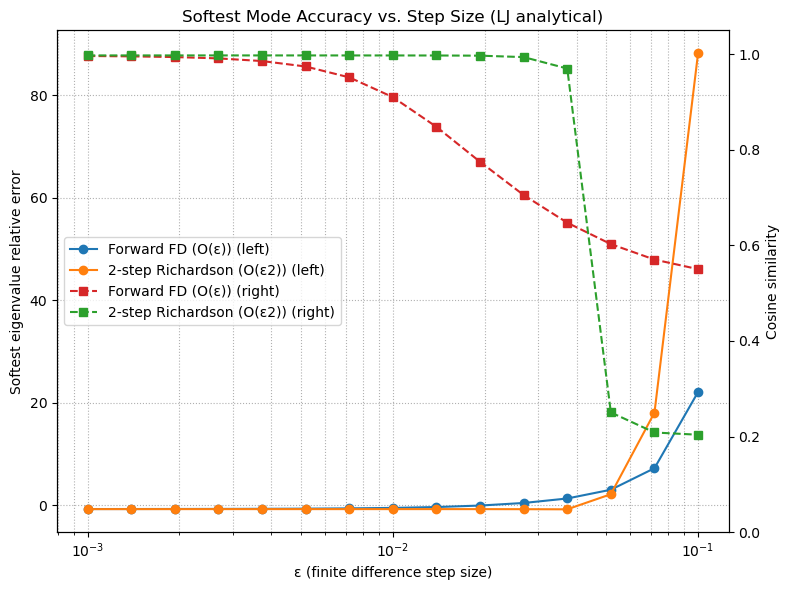

In [42]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# Left y-axis: relative error
ax1.plot(epsilons, softest_evals_fd, 'o-', color='tab:blue', label='Forward FD (O(ε)) (left)')
ax1.plot(epsilons, softest_evals_e2, 'o-', color='tab:orange', label='2-step Richardson (O(ε2)) (left)')
ax1.set_xlabel("ε (finite difference step size)")
ax1.set_ylabel("Softest eigenvalue relative error")
ax1.tick_params(axis='y')
ax1.set_xscale("log")
ax1.grid(True, which="both", ls=":")

# Right y-axis: cosine similarity
ax2 = ax1.twinx()
ax2.plot(epsilons, cosine_sims_fd, 's--', color='tab:red', label='Forward FD (O(ε)) (right)')
ax2.plot(epsilons, cosine_sims_e2, 's--', color='tab:green', label='2-step Richardson (O(ε2)) (right)')
ax2.set_ylabel("Cosine similarity")
ax2.tick_params(axis='y')
ax2.set_ylim(0, 1.05)

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center left')

plt.title("Softest Mode Accuracy vs. Step Size (LJ analytical)")
plt.tight_layout()
plt.show()